<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

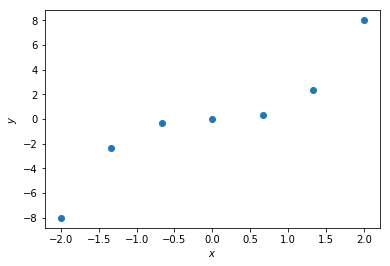

In [30]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

In [3]:
from sklearn.tree import DecisionTreeRegressor

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [5]:
y[:3].mean()

-3.5555555555555554

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [27]:
def disp(X, y):
    m = X.shape[0]
    mn = y.mean()
    return (y-mn).dot((y-mn).T)/m

In [33]:
def regression_var_criterion(X, y, t):
    idx1 = np.where(X<t)
    idx2 = np.where(X>=t)
    D = disp(X,y)
    D1 = disp(X[idx1], y[idx1])/y[idx1].size
    D2 = disp(X[idx2], y[idx2])/y[idx2].size 
    return D-D1-D2

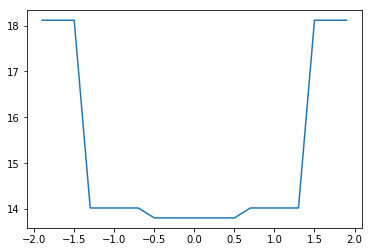

In [34]:
t_range = np.linspace(-1.9,1.9,20)
q = [regression_var_criterion(X,y,t) for t in t_range]
plt.plot(t_range, q)
plt.show()

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [7]:
7

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [61]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [67]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,ch_1,ch_2,ch_3,gl_1,gl_2,gl_3
id,,,,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,55,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0
2,51,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0
3,48,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0
4,47,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [63]:
df['age'] = (df.age // 365.25).astype(int)

In [65]:
df = pd.concat((df, pd.get_dummies(df.cholesterol, prefix='ch')),axis=1)

In [66]:
df = pd.concat((df, pd.get_dummies(df.gluc, prefix='gl')),axis=1).drop(columns=['gluc', 'cholesterol'])

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [49]:
train_test_split?

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(columns=['cardio']), df.cardio, test_size=.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [72]:
clf_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [74]:
export_graphviz(clf_tree, feature_names=X_train.columns, 
                out_file='../../img/hw_three_tree.dot', filled=True)

!dot -Tpng ../../img/hw_three_tree.dot -o ../../img/hw_three_tree.png
!rm ../../img/hw_three_tree.dot


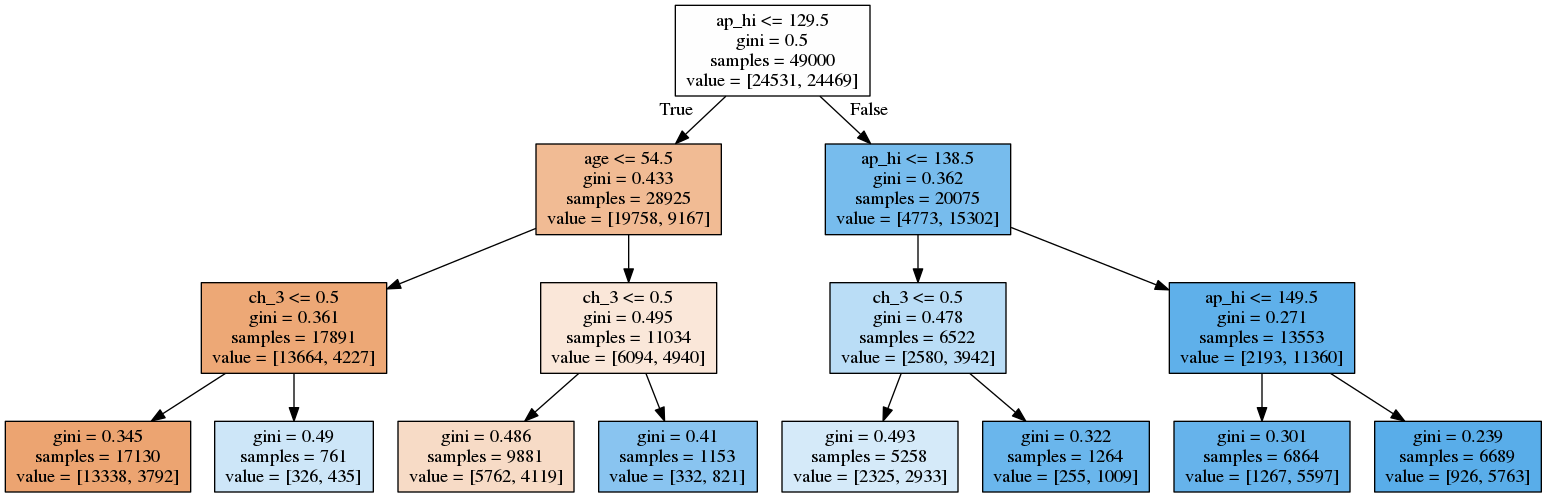

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [149]:
preds = clf_tree.predict(X_valid)
accuracy_score(y_valid, preds)

0.7212857142857143

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [130]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(clf_tree, tree_params, cv=5, n_jobs=-1, verbose=True)

In [131]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_

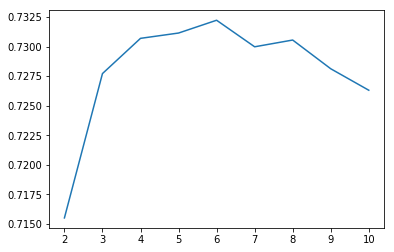

In [139]:
scores = [tree_grid.grid_scores_[i][1] for i in range(len(tree_params['max_depth']))]

plt.plot(tree_params['max_depth'], scores)
plt.show()

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [147]:
preds = tree_grid.best_estimator_.predict(X_valid)

In [148]:
accuracy_score(y_valid, preds)

0.7256666666666667

In [153]:
(0.7212857142857143-0.7256666666666667)/0.7212857142857143

-0.006073809995378613

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [172]:
from sklearn.preprocessing import LabelEncoder

In [231]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [232]:
df.age = (df.age // 356.25).astype(int)

In [233]:
df = pd.concat((df, pd.get_dummies(df.cholesterol, prefix='ch')),axis=1)

In [234]:
df = df.drop(columns=['alco', 'cholesterol', 'height', 'weight', 'ap_lo', 'gluc', 'active'])

In [235]:
enc = LabelEncoder()
df['male'] = enc.fit_transform(df.gender)

In [236]:
df.drop(columns=['gender'], inplace=True)

In [237]:
df['ap_0'] = df.apply(lambda row: ((row.ap_hi>= 120) & (row.ap_hi<140))+0, axis=1)

In [238]:
df['ap_1'] = df.apply(lambda row: ((row.ap_hi>= 140) & (row.ap_hi<160))+0, axis=1)

In [239]:
df['ap_2'] = df.apply(lambda row: ((row.ap_hi>= 160) & (row.ap_hi<180))+0, axis=1)

In [240]:
df['age_0'] = df.apply(lambda row: ((row.age>= 45) & (row.age<50))+0, axis=1)

In [241]:
df['age_1'] = df.apply(lambda row: ((row.age>= 50) & (row.age<55))+0, axis=1)

In [242]:
df['age_2'] = df.apply(lambda row: ((row.age>= 55) & (row.age<60))+0, axis=1)

In [243]:
df['age_3'] = df.apply(lambda row: ((row.age>= 60) & (row.age<65))+0, axis=1)

In [244]:
df.drop(columns=['age', 'ap_hi'], inplace=True)

In [248]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(columns=['cardio']), df.cardio, test_size=.3, random_state=17)

In [249]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=17)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [255]:
dot_source = export_graphviz(tree_clf, feature_names=X_train.columns, filled=True, out_file=None)

In [260]:
import graphviz as gv

In [261]:
graph = gv.Source(dot_source)

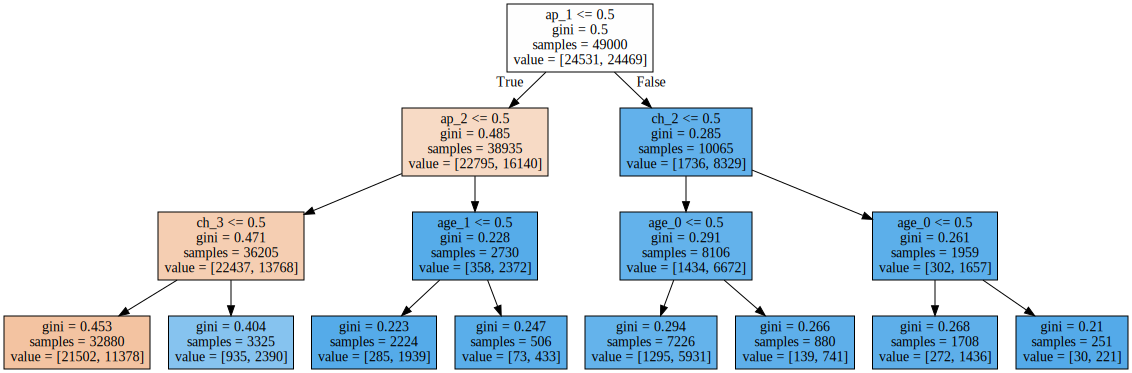

In [262]:
graph

In [ ]:
# Ваш код здесь